# Incremental SVD

### 패키지 불러오기

In [1]:
import utils
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from numpy.random import Generator, PCG64

### 기본셋팅 함수

In [2]:
def extract_category_mean(df_, col):
    """
    데이터프레임에서 특정 column의 평균값을 가진 데이터프레임을 만듦
    
    Parameters
    ----------
    df_ : like pandas.dataframe
        nan이 없는 user x item matrix 데이터프레임. 
   
    col : str
        대상 column 이름. 
    
    Returns
    ----------
    col_dict : dict
        key값은 column에 해당하는 index 값, 'mean' column은 해당 key값의 평균값인 dict. 
    """

    col_dict = {}
    
    if col == 'user':
        user_mean = np.nanmean(df_, axis=1)
        for i in range(len(df_)):
            col_dict[i] = user_mean[i]

    return col_dict


def normalized_df(matrix_, fill_option='item'):
    """
    user x item matrix 데이터 프레임에서 nan 값을 item 평균 또는 user 평균값으로 채우는 함수
    
    Parameters
    ----------
    matrix_ : like array
        user x item matrix로 nan 값이 있는 상태의 array.
    
    fill_option : str
        nan값을 채울 기준. 
      
            - item : item의 평균값으로 채움
            - user : user의 평균값으로 채움
            - zero : 0값으로 채움
      
    Returns
    ----------
    norm_pivot : like pandas.dataframe
        nan값을 채우고 user별 평균값을 뺀 normalized된 matrix. 
    
    col_dict : dict
        key값은 matrix의 index 번호, value 값은 해당 index 번호의 mean 값을
        가지는 dict
    """
    
    if fill_option == 'item':
        mean = np.nanmean(np.nanmean(matrix_, axis=0))

    elif fill_option == 'user':
        mean = np.nanmean(np.nanmean(matrix_, axis=1))
    
    elif fill_option == 'zero':
        mean = 0
    
    matrix_[np.isnan(matrix_)] = mean
    col_dict = extract_category_mean(matrix_, 'user')
    
    user_mean_list = [] 
    for i in range(len(matrix_)):
        mean = col_dict[i]
        user_mean_list.append(mean)
    
    user_mean_list = np.array(user_mean_list).reshape(-1,1)
    #user_mean_list = mean_df.loc[norm_pivot.index.tolist(), :]['mean'].values.reshape(-1,1)

    matrix_ = matrix_ - user_mean_list
    
    return matrix_, col_dict



def make_origin_pivot(ratings_):
    """
    userID, MovieID, Rating을 column으로 가진 데이터프레임을 user x item(MovieID) matrix 형태로 만듦(각 원소 값은 rating 값)
    
    Parameters
    ----------
    ratings_ : like pandas.dataframe
        userID, MovieID, Rating을 column으로 가진 데이터프레임. 
    
    Returns
    ----------
    origin_pivot : like pandas.dataframe
        user x item(MovieID) matrix (각 원소 값 : rating 값). 
    """
    # user x item matrix 만들기
    origin_pivot = ratings_.pivot(index='UserID', columns='MovieID',values='Rating')
    origin_pivot.index.name = None
    origin_pivot.columns.name = None
    print('origin_pivot')
    print(origin_pivot.head())
    
    return origin_pivot
    
def make_train_pivot(pivot_, test_pairs_):
    """
    user x item matrix에서 test에 해당하는 userID, MovieID의 rating값을 nan으로 만듦
    
    Parameters
    ----------
    pivot_ : like pandas.dataframe
        user x item(MovieID) matrix. 
    
    test_pairs_ : list
        [(userid1, movieid1, rating1),(userid2, movieid2, rating2),...]와 같은 형태의 list. 
    
    Returns
    ----------
    f_pivot : like pandas.dataframe
        test에 해당하는 데이터가 nan 처리된 user x item matrix. 
    """
    
    f_pivot = pivot_.copy()
    for i in range(len(test_pairs_)):
        user = test_pairs_[i][0]
        item = test_pairs_[i][1]
        f_pivot[user][item] = np.nan
    
    return f_pivot
        


def extract_test_info(ratings_, test_ind_):
    """
    test 값에 대한 userid, itemid, rating 값을 추출함
    
    Parameters
    ----------
    ratings_ : like pandas.dataframe
        userID, MovieID, Rating을 column으로 가진 데이터프레임. 
    
    test_ind_ : like list
        ratings_에서 test에 해당하는 index 번호 list
    
    Returns
    ----------
    test_pairs : list
        [(userid1, movieid1, rating1),(userid2, movieid2, rating2),...]와 같은 형태의 list. 
    
    """
    test_users = ratings_.loc[test_ind_,'UserID'].tolist()
    test_items = ratings_.loc[test_ind_,'MovieID'].tolist()
    
    test_ratings = ratings_.loc[test_ind_,'Rating'].tolist()
    test_pairs = [(i,j,k) for i,j,k in zip(test_users, test_items,test_ratings)]
    return test_pairs

### Incremental_SVD 알고리즘 class

In [3]:
class incremental_svd:
    
    def __init__(self, basis_num, seed_num, k_, ratings, key_dict, mean_dict):
        self.basis_num = basis_num
        self.seed_num = seed_num
        self.k_ = k_
        self.set_ratings(ratings, key_dict, mean_dict)
        
    def set_ratings(self, ratings, key_dict, mean_dict):
        """
        점수 관련 데이터를 class 변수에 저장함

        Parameters
        ----------
        ratings : like array
            user x item matrix. 각 값은 normalized 된 점수 값임
        key_dict : dict
            - key값은 'user', 'item'으로 나뉨
              - user : key값으로 user번호, value는 해당하는 index값 .
              - item : key값으로 item번호, value는 해당하는 index값 .
        mean_dict : dict
            key값은 index 번호, value는 index에 해당하는 user의 평균 점수 값을 가진
            dict

        Returns
        -------
        None.

        """
        self.ratings = ratings
        self.key_dict = key_dict
        self.mean_dict = mean_dict
    
    def get_values_by_key(self, var, key_list):
        """
        item 또는 user 번호를 넣으면 user x item의 matrix에 해당하는 index 번호를
        반환하는 함수

        Parameters
        ----------
        var : str
            item 또는 user.
        key_list : like list
            user 또는 item 번호를 가진 list.

        Returns
        -------
        var_list : list
            matrix에서 user 또는 item 번호에 해당하는 index 값.

        """

        var_list = []
        for key in key_list:
            value = self.key_dict[var][key]
            var_list.append(value)
        return var_list
    
    def split_basis_rest(self):
        """
        user x item matrix에서 user를 basis와 rest로 나누는 함수

        Returns
        -------
        None.

        """
        
        all_index = [i for i in range(self.ratings.shape[0])]
        rg = Generator(PCG64(self.seed_num))
        basis_index = rg.choice(all_index, self.basis_num,
                                replace=False).tolist()
        rest_index = np.setdiff1d(all_index, basis_index).tolist()
        
        self.basis_index = basis_index
        self.rest_index = rest_index

        basis_pivot = self.ratings[basis_index,:]
        rest_pivot = self.ratings[rest_index,:]
        
        print('basis_pivot shape : %s,%s'%(basis_pivot.shape[0],basis_pivot.shape[1]))
        print('rest_pivot shape : %s,%s'%(rest_pivot.shape[0],rest_pivot.shape[1]))
    
    
    def svd(self):
        """
        user x item matrix에 SVD를 적용함. latent variable은 k값까지만 기준으로 함.

        Returns
        -------
        u : numpy.array
            SVD의 U에 해당하는 값.
        s : numpy.array
            SVD의 S에 해당하는 값.
        vh : numpy.array
            SVD의 Vh에 해당하는 값.

        """

        basis_pivot = self.ratings[self.basis_index,:]
        u, s, vh = np.linalg.svd(basis_pivot, full_matrices=False)
        s = np.diag(s)
        u = u[:,:self.k_]
        s = s[:self.k_,:self.k_]
        vh = vh[:self.k_,:]
        print('U shape : %s'%(u.shape,))
        print('S shape : %s'%(s.shape,))
        print('Vh shape : %s'%(vh.shape,))
        
        return u, s, vh
    
    
    def make_incremental_u_matrix(self, rest_pivot_, vh_, s_):
        """
        원래 matrix에 추가된 데이터를 변형시켜 SVD의 U 부분에 추가함.
        
        Parameters
        ----------
        rest_pivot_ : like pandas.dataframe
            새로 들어온 user x item matrix
        
        vh_ : like numpy.array
            기존 SVD 분해 결과의 V 전치행렬
        
        s_ : like numpy.array
            기존 SVD 분해 결과의 S 행렬
            
        Returns
        ----------
        rest_u : like numpy.array
            새로 들어온 user x item matrix의 SVD U 행렬
        
        """
        
        # 2. basis를 제외한 나머지 값에 대한 u값 구하기.
        rest_u = np.matmul(np.matmul(rest_pivot_, vh_.T), np.linalg.inv(s_))
        print('incremental_u_matrix shape : %s'%(rest_u.shape,))
        
        return rest_u
    
    
    def make_predicted_matrix(self, u_,s_,vh_):
        """
        원래 matrix에 추가된 데이터를 변형시켜 SVD의 U 부분에 추가함.
        
        Parameters
        ----------
        u_ : like numpy.array
            incremental 방식을 통해 기존 U와 새로 들어온 U가 합쳐진 U
        
        s_ : like numpy.array
            SVD 분해 결과의 S 행렬
        
        vh_ : like numpy.array
            SVD 분해 결과의 V 전치행렬
        
        """
        
        self.sqrted_s = np.sqrt(s_)
        self.user_part = np.matmul(u_,self.sqrted_s)
        self.item_part = np.matmul(self.sqrted_s,vh_)
        
        
    def concat_basis_rest(self, basis_u, rest_u):
        """
        SVD의 U에서 basis와 rest를 합치는 함수

        Parameters
        ----------
        basis_u : numpy.array
            basis의 U에 해당하는 array.
        rest_u : TYPE
            rest의 U에 해당하는 array.

        Returns
        -------
        user : numpy.array
            basis와 rest의 U가 합친 array

        """
        user = np.empty([len(basis_u)+len(rest_u),basis_u.shape[1]])
        
        user[self.basis_index,:] = basis_u
        user[self.rest_index,:] = rest_u

        return user
    
    def make_matrix(self):
        """
        basis의 U와 rest의 U를 합쳐 최종적인 SVD의 U, S, Vh를 만듦

        Returns
        -------
        None.

        """
        basis_u, s, vh = self.svd()
        rest_pivot = self.ratings[self.rest_index,:]
        rest_u = self.make_incremental_u_matrix(rest_pivot, vh, s)
        u = self.concat_basis_rest(basis_u, rest_u)
        del basis_u, rest_u
        
        self.make_predicted_matrix(u,s,vh)
        self.u, self.s, self.vh = u, s, vh
    
    
    def fit(self):
        """
        incremental SVD를 만드는 함수

        Returns
        -------
        None.

        """
        self.split_basis_rest()
        self.make_matrix()
        
    
    def make_pred_value(self,user, item):
        """
        해당하는 user, item 번호의 pred 값을 생성하는 함수

        Parameters
        ----------
        user : like list
            user 번호를 가진 list.
        item : like list
            item 번호를 가진 list.

        Returns
        -------
        result : float
            최종 pred 값.
            
        """

        user_ind = self.get_values_by_key('user',user )
        item_ind = self.get_values_by_key('item',item )
        mean_list = []
        for ind in user_ind:
            mean = self.mean_dict[ind]
            mean_list.append(mean)
        mean_list = np.array(mean_list).reshape(-1,1)

        result = mean_list + np.matmul(self.user_part[user_ind,:],
                                       self.item_part[:,item_ind])
        result = result[0][0]
        return result
    
    def make_pred_matrix(self):
        """
        pred user x item matrix를 만드는 함수

        Returns
        -------
        result : numpy.array
            pred user x item matrix.

        """
        mean_list = np.array([v for v in self.mean_dict.values()]).reshape(-1,1)
        result = mean_list + np.matmul(self.user_part,self.item_part)
        
        return result
        
    def predict(self, test_pairs, make_matrix=False):
        """
        user와 item 번호에 맞는 예측값, 실제값을 만듦

        Parameters
        ----------
        test_pairs : list
            [(userid1, movieid1, rating1),(userid2, movieid2, rating2),...]와 같은 형태의 list. 
        make_matrix : boolen, optional
            True면 pred matrix를 활용하고 return으로 받음. 
            False면 pred matrix를 안 만듦. The default is False.

        Returns
        -------
        pred_list : list
            예측값.
        true_list : list
            실제값.
        pred_matrix : numpy.array
            pred user x item matrix

        """
        pred_list = []
        true_list = []
        if make_matrix == False:
            
            for user, item, rating in test_pairs:

                pred = self.make_pred_value([user],[item])
                pred_list.append(pred)
                true_list.append(rating)
            pred_list = np.array(pred_list).reshape(-1,)
            true_list = np.array(true_list).reshape(-1,)
            return pred_list, true_list
            
        else:
            self.make_pred_matrix()
            pred_matrix = self.make_pred_matrix()
            test_pairs = np.array(test_pairs)

            user_inds = self.get_values_by_key('user',test_pairs[:,0])
            item_inds = self.get_values_by_key('item',test_pairs[:,1])
            
            true_list = test_pairs[:,2].reshape(-1,)

            pred_list = pred_matrix[user_inds,item_inds]

            return pred_list, true_list, pred_matrix


### 실험 돌리기 위한 함수

In [4]:
def experiment(test_rate, seed_num, ratings,origin_pivot, k, key_dict, 
               result_return_option = False):
    """
    test 데이터 비율로 실험하기 위한 함수

    Parameters
    ----------
    test_rate : float
        test 데이터 비율.
    seed_num : int
        random seed 번호.
    ratings : pandas.dataframe
        user, item, 점수값을 column으로 가진 dataframe.
    origin_pivot : pandas.dataframe
        user x item인 dataframe. value는 점수값임
    k : int
        SVD에서 활용할 k값.
    key_dict : dict
        - key값은 'user', 'item'으로 나뉨
          - user : key값으로 user번호, value는 해당하는 index값 .
          - item : key값으로 item번호, value는 해당하는 index값 .
    result_return_option : boolean, optional
        True면 result_dict도 같이 반환. 
        False면 mae만 가진 test_dict값만 반환함. The default is False.

    Returns
    -------
    test_dict : dict
        key값은 basis num, value는 해당하는 basis num의 mae.
    result_dict : dict
        key값은 basis num, 안에는 pred, true, pred matrix, test_pairs가 있음
    """
    X_ind = ratings.index.values
    test_dict = {}
    rg = Generator(PCG64(seed_num))
    test_index = rg.choice(X_ind, int(len(X_ind)*test_rate), replace=False)
    basis_num_list = [600,650,700,750,800,850,900,943]
    count = 0
    test_ind = X_ind[test_index]
    #train_ind = X_ind[np.setdiff1d(X_ind,test_index)]
    test_pairs = extract_test_info(ratings, test_ind)
    changed_origin_pivot = make_train_pivot(origin_pivot, test_pairs)
    changed_origin_pivot = changed_origin_pivot.values
    norm_pivot, mean_dict = normalized_df(changed_origin_pivot, fill_option='item')
    result_dict = {}
    for basis_num  in basis_num_list:
        
        model = incremental_svd(basis_num, seed_num, k, norm_pivot, key_dict, mean_dict)
        model.fit()
        pred_list, true_list, matrix = model.predict(test_pairs, True)
    
        mae = np.mean(np.abs(np.array(true_list) - np.array(pred_list)))
        
        count+=1
        print('%s/%s 완료'%(count, len(basis_num_list)))
        
        test_dict[basis_num] = mae
        if result_return_option == True:
            result_dict[basis_num] = {'pred':pred_list, 'true':true_list,
                                      'matrix':matrix, 'test_pairs':test_pairs}
    if result_return_option == True:
        return test_dict, result_dict
    else:
        return test_dict

### main 

In [5]:
# data path 설정
data_path = utils.data_path
raw_path = utils.raw_path

# 데이터 불러오기
ratings = pd.read_csv(raw_path+'/ml-100k/u.data', delimiter='\t', names=['UserID','MovieID','Rating','Timestamp'], engine='python')


# 초기값 세팅
seed_num= 50000

# ratings의 index 값 구하기
X_ind = ratings.index.values

# 실험 때 쓰는 파라미터
k = 14

# 1. pivot matrix로 만들기
origin_pivot = make_origin_pivot(ratings)

# user 번호나 item 번호를 넣으면 해당하는 index값이 나오도록 함.
key_dict = {}
key_dict['user'] = {}
key_dict['item'] = {}
for i in range(len(origin_pivot.index)):
    user = origin_pivot.index[i]
    key_dict['user'][user] = i
    
for j in range(len(origin_pivot.columns)):
    item = origin_pivot.columns[j]
    key_dict['item'][item] = j 

origin_pivot
   1     2     3     4     5     6     7     8     9     10    ...  1673  \
1   5.0   3.0   4.0   3.0   3.0   5.0   4.0   1.0   5.0   3.0  ...   NaN   
2   4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   2.0  ...   NaN   
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
5   4.0   3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   

   1674  1675  1676  1677  1678  1679  1680  1681  1682  
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 1682 columns]


In [7]:
test_dict1, result_1 = experiment(0.2, seed_num, ratings, origin_pivot, k, key_dict, True)
test_dict2, result_2 = experiment(0.5, seed_num, ratings, origin_pivot, k, key_dict, True)
test_dict3, result_3 = experiment(0.8, seed_num, ratings, origin_pivot, k, key_dict, True)

basis_pivot shape : 600,1682
rest_pivot shape : 343,1682
U shape : (600, 14)
S shape : (14, 14)
Vh shape : (14, 1682)
incremental_u_matrix shape : (343, 14)
1/8 완료
basis_pivot shape : 650,1682
rest_pivot shape : 293,1682
U shape : (650, 14)
S shape : (14, 14)
Vh shape : (14, 1682)
incremental_u_matrix shape : (293, 14)
2/8 완료
basis_pivot shape : 700,1682
rest_pivot shape : 243,1682
U shape : (700, 14)
S shape : (14, 14)
Vh shape : (14, 1682)
incremental_u_matrix shape : (243, 14)
3/8 완료
basis_pivot shape : 750,1682
rest_pivot shape : 193,1682
U shape : (750, 14)
S shape : (14, 14)
Vh shape : (14, 1682)
incremental_u_matrix shape : (193, 14)
4/8 완료
basis_pivot shape : 800,1682
rest_pivot shape : 143,1682
U shape : (800, 14)
S shape : (14, 14)
Vh shape : (14, 1682)
incremental_u_matrix shape : (143, 14)
5/8 완료
basis_pivot shape : 850,1682
rest_pivot shape : 93,1682
U shape : (850, 14)
S shape : (14, 14)
Vh shape : (14, 1682)
incremental_u_matrix shape : (93, 14)
6/8 완료
basis_pivot shape 

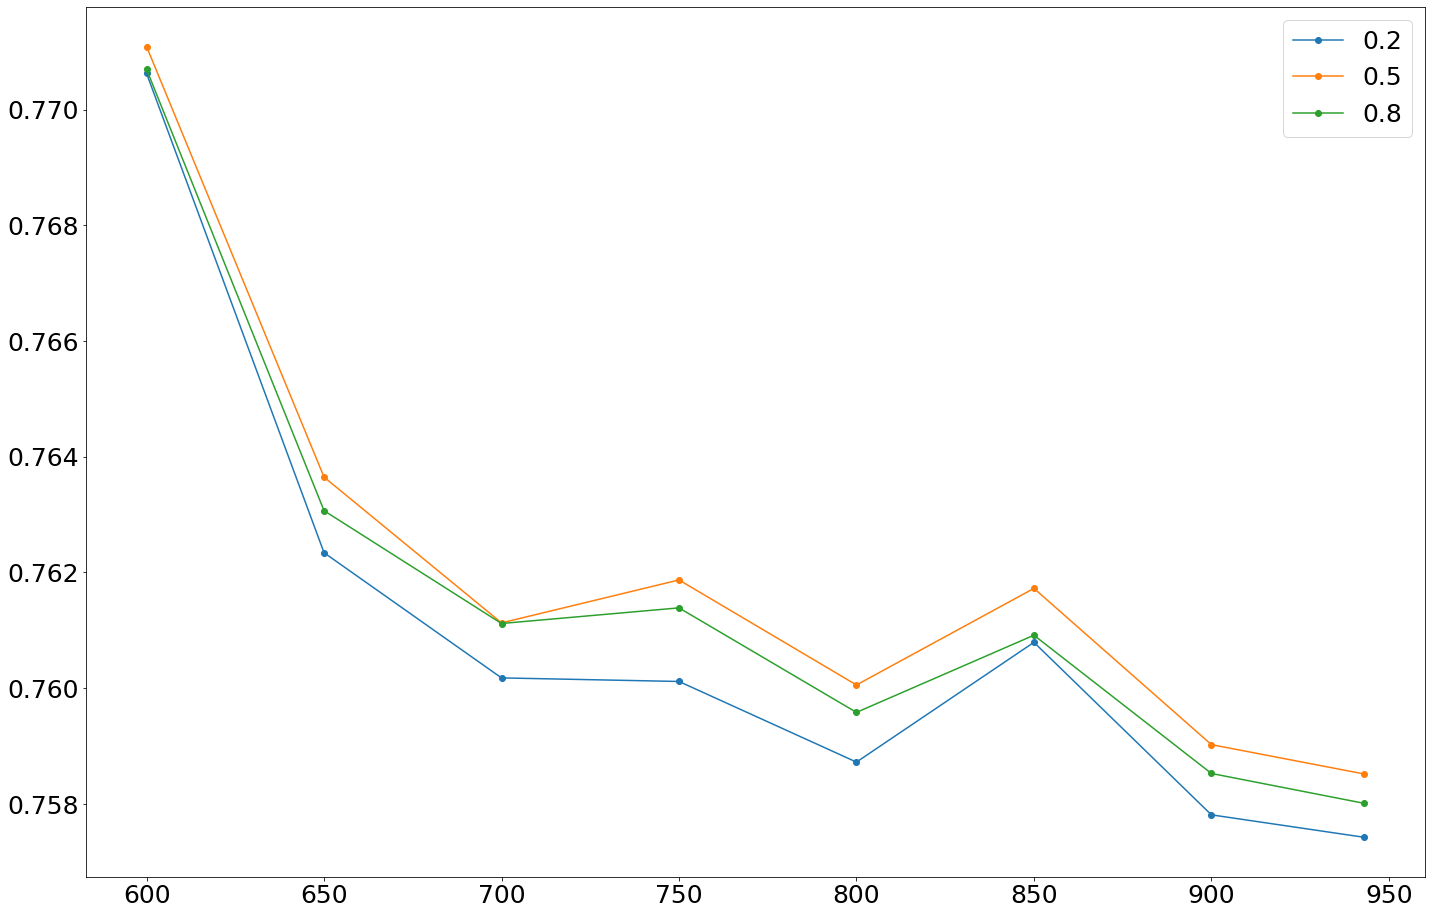

In [8]:
plt.rc('font', size=25)
plt.figure(figsize=(24,16))
plt.plot([600,650,700,750,800,850,900,943], [v for v  in test_dict1.values()], marker='o', label='0.2')
plt.plot([600,650,700,750,800,850,900,943], [v for v  in test_dict2.values()], marker='o', label='0.5')
plt.plot([600,650,700,750,800,850,900,943], [v for v  in test_dict3.values()], marker='o', label='0.8')
plt.legend()
plt.show()